In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [5]:
import torch
from torch import nn
import PIL
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [6]:
assert torch.__version__=='1.8.1'

In [7]:
np.random.seed(0)
torch.manual_seed(0)

In [207]:
#

In [8]:
trainset = datasets.MNIST('../digit_MNIST_data/', download = True, train = True, transform = transforms.ToTensor())
testset = datasets.MNIST('../digit_MNIST_data/', download = True, train = False, transform = transforms.ToTensor())

In [9]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64)
test_loader = torch.utils.data.DataLoader(testset,batch_size=64)

In [10]:
class MaskedConv2d(nn.Conv2d):
    #sourc: https://github.com/pilipolio/learn-pytorch/blob/master/201708_IconPixelCNN.ipynb
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [13]:
def blur(img,blur_size,seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    blur = nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size=blur_size[0],bias=False, padding=blur_size[0]//2,stride=1)
    blur.weight = nn.Parameter(torch.ones((1,1,blur_size[0],blur_size[1]))/(blur_size[0]*blur_size[1]),requires_grad=False)
    return blur.forward(img) + torch.normal(mean=0.0,std=0.1, size=img.shape)

In [22]:
class PixelCNN(nn.Module):
    n_channels = 20
    kernel_size = 3
    padding = 1
    #n_pixels_out = 2 # binary 0/1 pixels
    #nr_mix
    
    def __init__(self, nr_mix):
        super(PixelCNN, self).__init__()
        self.nr_mix = nr_mix
        """self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=True), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=True), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels//2, kernel_size=self.kernel_size, padding=self.padding, bias=True), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels//2, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=True), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=True), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=3*self.nr_mix, kernel_size=1)
        )"""
        
        self.layer1 = nn.Sequential(MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size+2, padding=self.padding+1, bias=True), nn.BatchNorm2d(self.n_channels), nn.ReLU(True))
        self.layer2 = nn.Sequential(MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=True), nn.BatchNorm2d(self.n_channels), nn.ReLU(True))
        self.layer3 = nn.Sequential(MaskedConv2d('B', self.n_channels, self.n_channels//2, kernel_size=self.kernel_size, padding=self.padding, bias=True), nn.BatchNorm2d(self.n_channels//2), nn.ReLU(True))
        self.layer4 = nn.Sequential(MaskedConv2d('B', self.n_channels//2, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=True), nn.BatchNorm2d(self.n_channels), nn.ReLU(True))
        #self.layer5 = nn.Sequential(MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=True), nn.BatchNorm2d(self.n_channels), nn.ReLU(True))
        self.layer6 = nn.Sequential(nn.Conv2d(in_channels=self.n_channels, out_channels=3*self.nr_mix, kernel_size=1))

        
        self.blur_layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding), nn.BatchNorm2d(self.n_channels), nn.ReLU(True))
        
        self.blur_layer2 = nn.Sequential(nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding), nn.BatchNorm2d(self.n_channels), nn.ReLU(True))
        self.blur_layer3 = nn.Sequential(nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding), nn.BatchNorm2d(self.n_channels), nn.ReLU(True))
        self.blur_layer4 = nn.Sequential(nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding), nn.BatchNorm2d(self.n_channels), nn.ReLU(True))
        #self.blur_layer5 = nn.Sequential(nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding), nn.BatchNorm2d(self.n_channels), nn.ReLU(True))
        self.final_layer = nn.Sequential(nn.Conv2d(in_channels=self.n_channels+self.n_channels, out_channels=3*self.nr_mix, kernel_size=1))
        
    def forward(self, x, x_blur):
        #x = self.layers(x) # shape  = [batch, 3*nr_mix, H, W]
        x = self.layer1(x)
        x = self.layer2(x)  
        #residual = x
        x = self.layer3(x) 
        x = self.layer4(x) 
        
        #x = self.layer5(x) 
        #x = x + residual   
        
        #x = self.layer6(x)

        x_blur = self.blur_layer1(x_blur)
        x_blur = self.blur_layer2(x_blur)
        x_blur = self.blur_layer3(x_blur)
        x_blur = self.blur_layer4(x_blur)
        #x_blur = self.blur_layer5(x_blur)
        
        x = torch.cat((x,x_blur), dim=1)
        x = self.final_layer(x)

        softmax = nn.Softmax(dim=1)
        softplus = nn.Softplus()
        sigmoid = nn.Sigmoid()

        mu =  x[:, :self.nr_mix, :, :]
        var = x[:, self.nr_mix:2*self.nr_mix, :, :]
        pi_mix = x[:, 2*self.nr_mix:3*self.nr_mix, :, :]
        
        mus = torch.empty(mu.shape)
        mus[:, 0, :, :] = mu[:, 0, :, :]
        for i in range(1, self.nr_mix):
            mus[:, i, :, :] = mus[:, i-1, :, :] + softplus(mu[:, i, :, :])

        mus = sigmoid(mus)
        var = softplus(var)
        var = torch.clamp(var, min=0.00000001)
        pi_mix = softmax(pi_mix)
        
        x = torch.cat((mus, var, pi_mix), dim=1)

        return x

In [18]:
def Mixture_Gauss_NLLLoss(target, pred): # mu, sigma, pi_mix):
    total_lik = 0#torch.zeros(target[:,0,:,:].shape)
    loss_func  = nn.GaussianNLLLoss(full=False, reduction='none')
    #sigma = torch.clamp(sigma, 0.000001)
    nr_mix = int(pred.shape[1]/3)
    
    mu =  pred[:, :nr_mix, :, :]
    var = pred[:, nr_mix:2*nr_mix, :, :]
    pi_mix = pred[:, 2*nr_mix:3*nr_mix, :, :]
    var = torch.clamp(var,min=0.00000001)

    for i in range(nr_mix):

        loss = loss_func(torch.flatten(mu[:,i,:,:]), torch.flatten(target[:,0,:,:]), torch.flatten(var[:,i,:,:]))
        #print(loss.shape)
        likelihood = torch.exp(-loss)
        #print(target[:,0,:,:].shape)
        #print(likelihood.shape)
        #print(pi_mix[:,i,:,:].shape)
        #print(torch.flatten(pi_mix[:,i,:,:]).shape)
        total_lik += torch.flatten(pi_mix[:,i,:,:])*likelihood #sum , mean????

    
    gauss_mix_loss = torch.log(torch.clamp(total_lik, min=0.00000001))
    
    return -gauss_mix_loss.mean() 

In [23]:
pixel_cnn = PixelCNN(nr_mix=2)
loss_function  = Mixture_Gauss_NLLLoss
#optimizer = torch.optim.Adam(pixel_cnn.parameters(), lr=0.0005)
optimizer = torch.optim.Adam(pixel_cnn.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [24]:
epochs = 20
loss_vals_train = []
loss_vals_test = []

In [25]:
for e in range(epochs): # 5 epochs at maximum
    #torch.autograd.detect_anomaly()
    # Print epoch
    print(f'Starting epoch {e+1}')
    
    # Set current loss value
    current_loss = 0.0
    seed=0
    for im, _ in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        blur_im = blur(im,(5,5),seed)
        pred_mix = pixel_cnn(im, blur_im)

        loss = loss_function(im, pred_mix)

        # Perform backward pass
        loss.backward()
        # Perform optimization
        optimizer.step()
        # Print statistics
        current_loss += loss.item()
        seed+=1
    
    scheduler.step()

    print('Loss after mini-batch %5d: %.3f' %
                (e + 1, current_loss / len(train_loader)))    
    
    validation_loss = 0.0
    pixel_cnn.eval()
    seed=0
    for im, _ in test_loader:
        blur_im = blur(im,(5,5),seed)
        pred_mix = pixel_cnn(im, blur_im)
        
        loss_val = loss_function(im, pred_mix)
        validation_loss += loss_val.item()
        seed+=1

    print('Val Loss after mini-batch %5d: %.3f' %
                (e + 1, validation_loss / len(test_loader)))

    # Process is complete.
    loss_vals_train.append(current_loss/len(train_loader))
    loss_vals_test.append(validation_loss/len(test_loader))

print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: -0.844
Val Loss after mini-batch     1: -1.882
Starting epoch 2
Loss after mini-batch     2: -5.809
Val Loss after mini-batch     2: -5.914
Starting epoch 3
Loss after mini-batch     3: -5.932
Val Loss after mini-batch     3: -5.948
Starting epoch 4
Loss after mini-batch     4: -5.957
Val Loss after mini-batch     4: -5.965
Starting epoch 5
Loss after mini-batch     5: -5.971
Val Loss after mini-batch     5: -5.977
Starting epoch 6
Loss after mini-batch     6: -5.981
Val Loss after mini-batch     6: -5.986
Starting epoch 7
Loss after mini-batch     7: -5.989
Val Loss after mini-batch     7: -5.993
Starting epoch 8
Loss after mini-batch     8: -5.994
Val Loss after mini-batch     8: -5.996
Starting epoch 9
Loss after mini-batch     9: -5.999
Val Loss after mini-batch     9: -6.002
Starting epoch 10
Loss after mini-batch    10: -6.002
Val Loss after mini-batch    10: -6.005
Starting epoch 11
Loss after mini-batch    11: -6.005
Val Loss after 

In [26]:
torch.save(pixel_cnn.state_dict(), 'pixel_cnn_blur_9_Omega_sig_01.pt')

In [12]:
pixel_cnn = PixelCNN(nr_mix=2)
#pixel_cnn.load_state_dict(torch.load('pixel_cnn_blur_digits_10e.pt'))
#pixel_cnn.load_state_dict(torch.load('pixel_cnn_blur_digits_25e.pt'))
pixel_cnn.load_state_dict(torch.load('pixel_cnn_blur_11_Omega.pt'))
pixel_cnn.eval()

PixelCNN(
  (layer1): Sequential(
    (0): MaskedConv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): MaskedConv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): MaskedConv2d(20, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): MaskedConv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer6): Sequential(
    (0): Conv2d(20, 6, kernel_size=(1, 1), stride=(1, 1))
  )
 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'loss')

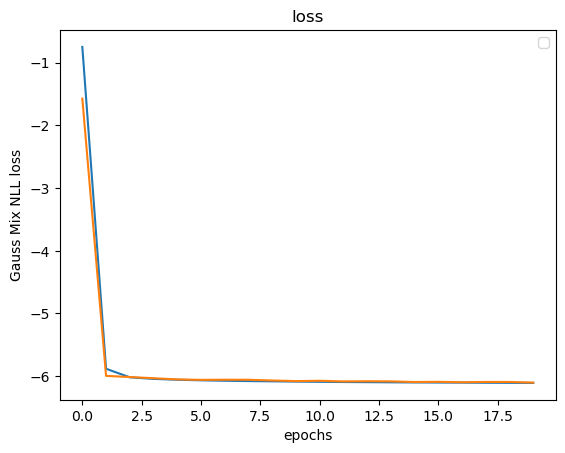

In [19]:
plt.plot(range(len(loss_vals_train)),loss_vals_train)
plt.plot(range(len(loss_vals_test)),loss_vals_test)
plt.xlabel('epochs')
plt.ylabel('Gauss Mix NLL loss')
plt.legend()
plt.title('loss')

In [14]:
#from scipy.stats import truncnorm

In [27]:
digits_imgs_train = torch.load('../digit_MNIST_data/MNIST/processed/training.pt')
digits_imgs_test = torch.load('../digit_MNIST_data/MNIST/processed/test.pt')

In [9]:
digits_imgs_test[0][2:3].shape

torch.Size([1, 28, 28])

In [28]:
def gen_im_mix_trunc(model, im_size, nbh_size, new_im_blur, blur_size):
    m, n = nbh_size

    pred_mu = np.zeros(im_size)
    pred_sigma2 = np.zeros(im_size)
    pred_mu2 = np.zeros(im_size)
    pred_sigma2_2 = np.zeros(im_size)
    pred_pi_mix = np.zeros(im_size)

    #h, w = blur_size
    #h = h//2
    #w = w//2

    new_im_bl = new_im_blur.clone()
    new_im = torch.zeros((1,1,28,28))

    for i in range(0, im_size[0]):
        for j in range(0, im_size[1]):
            
            
            output = model(new_im, new_im_bl)

           
            pi_mix_output = output[0,4:,i,j]
            mu_output = output[0,0:2,i,j].detach().numpy()
            sigma2_output = output[0,2:4,i,j].detach().numpy()
            
            pi_mix_sample = np.random.choice(2, 1, p=pi_mix_output.detach().numpy())[0]

            sample = np.random.normal(mu_output[pi_mix_sample], np.sqrt(sigma2_output[pi_mix_sample]))
            
            sample = np.clip(sample, 0.0, 1.0)

            new_im[:,:,i,j] = torch.from_numpy(np.asarray(sample))
            
            pred_mu[i,j] = mu_output[0]
            pred_sigma2[i,j] = sigma2_output[0]

            pred_mu2[i,j] = mu_output[1]
            pred_sigma2_2[i,j] = sigma2_output[1]

            pred_pi_mix[i,j] = pi_mix_output[0]    
    
    return new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix#, pred_mu3, pred_sigma_3, pred_pi_mix2

In [30]:
blurred_testset = blur(torch.unsqueeze(digits_imgs_test[0]/255,dim=1), (5,5),seed=0)

In [15]:
#new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix_trunc(pixel_cnn, (28,28), (5,5))

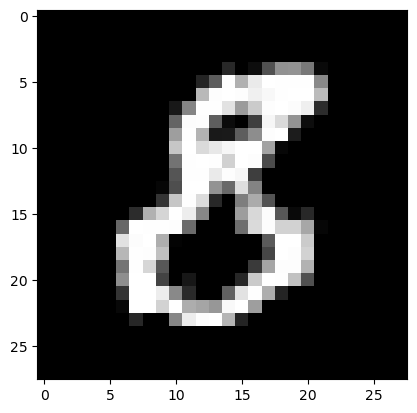

In [32]:
new_im, _, _, _, _, _ = gen_im_mix_trunc(pixel_cnn, (28,28), (5,5),new_im_blur=torch.unsqueeze(blurred_testset[1234], dim=0),blur_size=(5,5))
plt.imshow(new_im[0,0], vmin=0, vmax=1,cmap='gray')

nnn


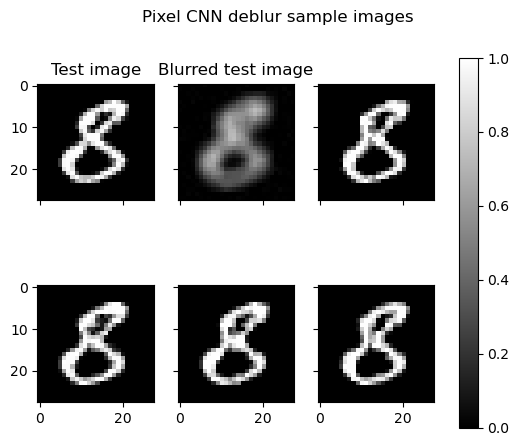

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3,sharex=True, sharey=True)
x = [0, 27]
y = [12, 12]
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    #im = ax.imshow(mnist_imgs_train[0][i]/255, vmin=0, vmax=1,cmap='gray')
    if i==0:
        im = ax.imshow(digits_imgs_test[0][1234]/255, vmin=0, vmax=1,cmap='gray')
    elif i ==1:
        im = ax.imshow(blurred_testset[1234,0], vmin=0, vmax=1,cmap='gray')
    else:
        new_im, _, _, _, _, _ = gen_im_mix_trunc(pixel_cnn, (28,28), (5,5),new_im_blur=torch.unsqueeze(blurred_testset[1234], dim=0),blur_size=(5,5))
        im = ax.imshow(new_im[0,0], vmin=0, vmax=1,cmap='gray')
        #ax.plot(x, y, color="red", linewidth=1)

image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('Pixel CNN deblur sample images')
axes[0,0].set_title("Test image")
axes[0,1].set_title("Blurred test image")
#plt.savefig('../figures_blur/CNN_blur_samp.jpg')
print('nnn')
#plt.show()

In [28]:
#plt.imshow(blurred_testset[1234,0], cmap='gray')

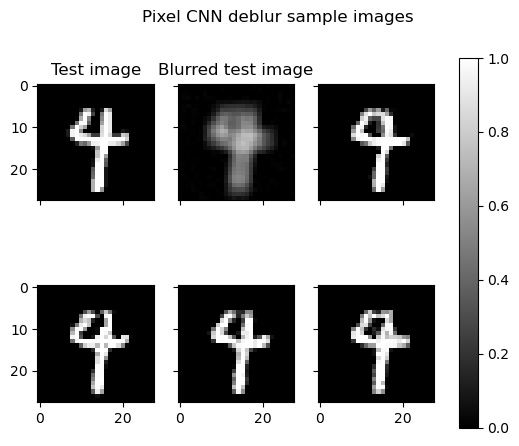

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=3,sharex=True, sharey=True)
x = [0, 27]
y = [12, 12]
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    #im = ax.imshow(mnist_imgs_train[0][i]/255, vmin=0, vmax=1,cmap='gray')
    if i==0:
        im = ax.imshow(digits_imgs_test[0][565]/255, vmin=0, vmax=1,cmap='gray')
    elif i ==1:
        im = ax.imshow(blurred_testset[565,0], vmin=0, vmax=1,cmap='gray')
    else:
        new_im, _, _, _, _, _ = gen_im_mix_trunc(pixel_cnn, (28,28), (5,5),new_im_blur=torch.unsqueeze(blurred_testset[565], dim=0),blur_size=(5,5))
        im = ax.imshow(new_im[0,0], vmin=0, vmax=1,cmap='gray')
        #ax.plot(x, y, color="red", linewidth=1)

image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('Pixel CNN deblur sample images')
axes[0,0].set_title("Test image")
axes[0,1].set_title("Blurred test image")
#plt.savefig('../figures_blur/CNN_blur_samp_2.jpg')

plt.show()

In [33]:
def blur_no_noise(img,blur_size):
    blur = nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size=blur_size[0],bias=False, padding=blur_size[0]//2,stride=1)
    blur.weight = nn.Parameter(torch.ones((1,1,blur_size[0],blur_size[1]))/(blur_size[0]*blur_size[1]),requires_grad=False)
    #return blur.forward(torch.unsqueeze(torch.unsqueeze(img,dim=0),dim=0))
    return blur.forward(img)

In [34]:
def y_minus_GX_samp(y,X_samp,num_samples):
    sample, _, _, _, _, _ = gen_im_mix_trunc(pixel_cnn, (28,28), (5,5), X_samp, (5,5)) #, (5,5))   (28,28), (5,5),new_im_blur=torch.unsqueeze(blurred_testset[1234], dim=0),blur_size=(5,5))
    nnn = np.abs(y - blur_no_noise(sample, (5,5)))
    return nnn, sample

In [26]:
y_min_GX_sampled, sampleee = y_minus_GX_samp(blurred_testset[356], torch.unsqueeze(blurred_testset[356],dim=0), 1)
#sampleee, _, _, _, _, _ = gen_im_mix(mlp_mix, blurred_testset[356,0], (5,5), (5,5))
blured_sampled = blur_no_noise(sampleee, (5,5))

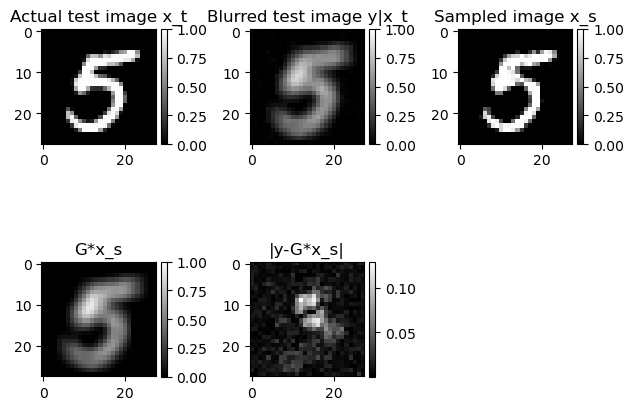

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=3)


im = axes.flat[0].imshow( digits_imgs_test[0][356]/255, vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image x_t")

im = axes.flat[1].imshow(blurred_testset[356,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Blurred test image y|x_t")

im = axes.flat[2].imshow(sampleee[0,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,2],fraction=0.046, pad=0.04)
axes[0,2].set_title("Sampled image x_s")

im = axes.flat[3].imshow(blured_sampled[0,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("G*x_s")

im = axes.flat[4].imshow(y_min_GX_sampled[0,0], cmap='gray')#vmin=0, vmax=1,
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("|y-G*x_s|")

axes[1,2].set_visible(False)

fig.tight_layout()
plt.savefig('../figures_blur/Pixeel_CNN_y_min_GX_s_1.jpg')

In [42]:
y_min_GX_sampled, sampleee = y_minus_GX_samp(blurred_testset[1234], torch.unsqueeze(blurred_testset[1234],dim=0), 1)
#sampleee, _, _, _, _, _ = gen_im_mix(mlp_mix, blurred_testset[356,0], (5,5), (5,5))
blured_sampled = blur_no_noise(sampleee, (5,5))

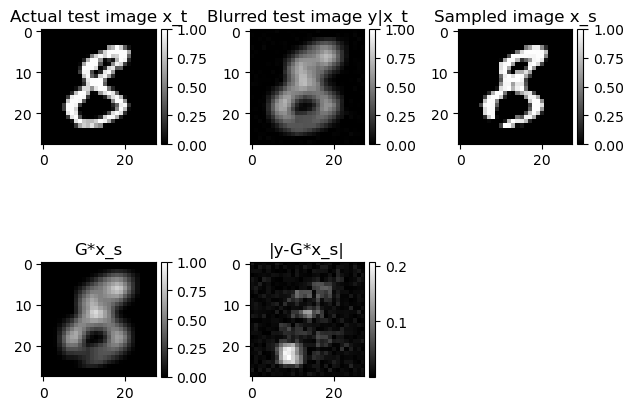

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3)


im = axes.flat[0].imshow( digits_imgs_test[0][1234]/255, vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image x_t")

im = axes.flat[1].imshow(blurred_testset[1234,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Blurred test image y|x_t")

im = axes.flat[2].imshow(sampleee[0,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,2],fraction=0.046, pad=0.04)
axes[0,2].set_title("Sampled image x_s")

im = axes.flat[3].imshow(blured_sampled[0,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("G*x_s")

im = axes.flat[4].imshow(y_min_GX_sampled[0,0], cmap='gray')#vmin=0, vmax=1,
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("|y-G*x_s|")

axes[1,2].set_visible(False)

fig.tight_layout()
plt.savefig('../figures_blur/Pixeel_CNN_y_min_GX_s_2.jpg')

In [35]:
def sample_many_ims(blurred_im,num_samples):

    blurred_samples = np.empty((0,blurred_im.shape[2],blurred_im.shape[3]))

    for i in range(num_samples):
        #sample = seq_sim(blurred_im,parameters_estimate, (5,5),blur_size=(5,5))
        sample, _, _, _, _, _ = gen_im_mix_trunc(pixel_cnn, (28,28), (5,5), blurred_im, (5,5)) 
        blurred_samples = np.concatenate((blurred_samples, np.expand_dims(sample[0,0], axis=0)), axis=0)
    return blurred_samples

In [36]:
def gen_im_mix_many_ims(model, im_size, nbh_size, new_im_blur, blur_size, num_ims):
    m, n = nbh_size

    h, w = blur_size
    h = h//2
    w = w//2

    #new_im_bl = new_im_blur.clone()
    new_im_bl = new_im_blur.clone().repeat(num_ims,1,1,1)

    new_im = torch.zeros((num_ims,1,28,28))

    for i in range(0, im_size[0]):
        for j in range(0, im_size[1]):
            
            output = model(new_im, new_im_bl)
           
            pi_mix_output = output[:,4:,i,j]
            mu_output = output[:,0:2,i,j].detach().numpy()
            sigma2_output = output[:,2:4,i,j].detach().numpy()
            #print(pi_mix_output)
            #pi_mix_sample = np.random.choice(2, (pi_mix_output.shape[0],1), p=pi_mix_output.detach().numpy())[0]
            pi_mix_sample = torch.multinomial(pi_mix_output, 1, replacement=False)
            #pi_mix_sample = np.random.choice(2, (pi_mix_output.shape[]), p=pi_mix_output.detach().numpy())[0]
  
            #pi_mix_sample = np.random.choice(pi_mix_output.shape[0], 1, p=pi_mix_output.detach().numpy())[0]
            
            pi_mix_sample = torch.squeeze(pi_mix_sample,dim=0)[0]
            #pi_mix_sample= torch.reshape(torch.squeeze(pi_mix_sample,dim=1),shape=(-1,5))

            #print(mu_output[:,pi_mix_sample[0]].shape)
            sample = np.random.normal(mu_output[:,pi_mix_sample], np.sqrt(sigma2_output[:,pi_mix_sample]))
            
            sample = np.clip(sample, 0.0, 1.0)
            #print(sample.shape)


            new_im[:,:,i,j] = torch.unsqueeze(torch.from_numpy(np.asarray(sample)),dim=1)

    return torch.squeeze(new_im,dim=1)#, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix#, pred_mu3, pred_sigma_3, pred_pi_mix2

In [105]:
#hhbhbh = gen_im_mix_many_ims(pixel_cnn, (28,28), (5,5), torch.unsqueeze(blurred_testset[356],dim=0), (5,5), 10)

In [117]:
#hhbhbh.shape

In [92]:
#plt.imshow(hhbhbh[3,0])

In [44]:
#m = torch.distributions.Multinomial(1, torch.tensor([1/6]*6),replace=False)
##m.sample()

In [94]:
#weights = torch.tensor([1/2.]*2, dtype=torch.float)
#out = torch.multinomial(weights, 20, replacement=True)
#out

In [96]:
#weights = torch.tensor([[7.8892e-05, 9.9992e-01],[7.8892e-05, 9.9992e-01],[7.8892e-05, 9.9992e-01],[7.8892e-05, 9.9992e-01],[7.8892e-05, 9.9992e-01]])

#out = torch.multinomial(weights, 1, replacement=False)

#out.shape
#torch.reshape(torch.squeeze(out,dim=1),shape=(-1,5)).shape

In [109]:
#def sample_many_ims(blurred_im,num_samples):

#    blurred_samples = np.empty((0,blurred_im.shape[2],blurred_im.shape[3]))

#    for i in range(num_samples):
#        sample = seq_sim(blurred_im,parameters_estimate, (5,5),blur_size=(5,5))
#        sample, _, _, _, _, _ = gen_im_mix_trunc(pixel_cnn, (28,28), (5,5), blurred_im, (5,5)) 
#        blurred_samples = np.concatenate((blurred_samples, np.expand_dims(sample[0,0], axis=0)), axis=0)
#    return blurred_samples

In [114]:
#fvgvgv = sample_many_ims(blurred_im=torch.unsqueeze(blurred_testset[356],dim=0),num_samples=10)

In [115]:
#fvgvgv.shape

In [45]:
many_samples0  = sample_many_ims(blurred_im=torch.unsqueeze(blurred_testset[356],dim=0),num_samples=100)

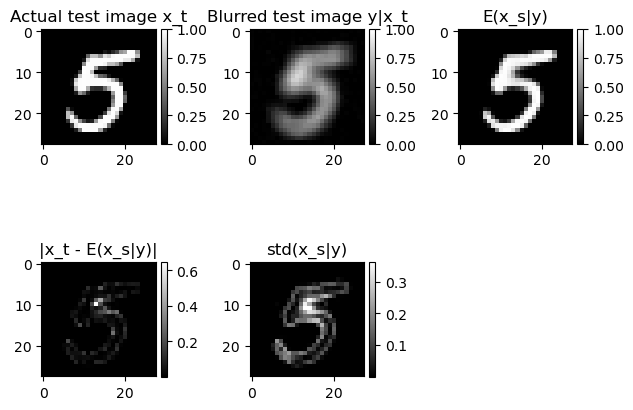

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=3)

im = axes.flat[0].imshow(digits_imgs_test[0][356]/255, vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image x_t")

im = axes.flat[1].imshow(blurred_testset[356,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Blurred test image y|x_t")

im = axes.flat[2].imshow(np.mean(many_samples0[:], axis=0), vmin=0, vmax=1,cmap='gray')#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,2],fraction=0.046, pad=0.04)
axes[0,2].set_title("E(x_s|y)")


im = axes.flat[3].imshow(np.abs(digits_imgs_test[0][356,:]/255-np.mean(many_samples0[:], axis=0)),cmap='gray')#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("|x_t - E(x_s|y)|")


im = axes.flat[4].imshow(np.std(many_samples0, axis=0)[:],cmap='gray')#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("std(x_s|y)")


axes[1,2].set_visible(False)

fig.tight_layout()
plt.savefig('../figures_blur/PIXEL_CNN_poserior_sample1.jpg')

In [47]:
many_samples1  = sample_many_ims(blurred_im=torch.unsqueeze(blurred_testset[1234],dim=0),num_samples=100)

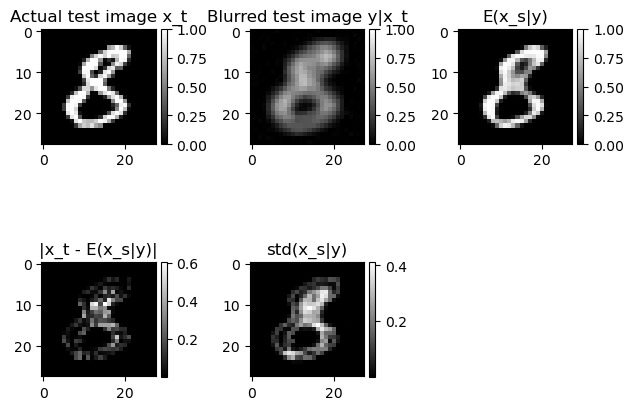

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=3)

im = axes.flat[0].imshow(digits_imgs_test[0][1234]/255, vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image x_t")

im = axes.flat[1].imshow(blurred_testset[1234,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Blurred test image y|x_t")

im = axes.flat[2].imshow(np.mean(many_samples1[:], axis=0), vmin=0, vmax=1,cmap='gray')#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,2],fraction=0.046, pad=0.04)
axes[0,2].set_title("E(x_s|y)")


im = axes.flat[3].imshow(np.abs(digits_imgs_test[0][1234,:]/255-np.mean(many_samples1[:], axis=0)),cmap='gray')#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("|x_t - E(x_s|y)|")


im = axes.flat[4].imshow(np.std(many_samples1, axis=0)[:],cmap='gray')#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("std(x_s|y)")


axes[1,2].set_visible(False)

fig.tight_layout()
plt.savefig('../figures_blur/PIXEL_CNN_poserior_sample2.jpg')

In [49]:
#import Gen_with_blur#.prior_model_CNN.PixelCNN

In [37]:
from prior_model_CNN import PixelCNN

In [38]:
import scipy.stats

In [39]:
pixel_cnn_prior = PixelCNN(nr_mix=2)
pixel_cnn_prior.load_state_dict(torch.load('../../CNN_gen/MNIST_data/pixel_cnn_digits_long1.pt'))
pixel_cnn_prior.eval()

PixelCNN(
  (layer1): Sequential(
    (0): MaskedConv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): MaskedConv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): MaskedConv2d(20, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): MaskedConv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer6): Sequential(
    (0): Conv2d(20, 6, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [40]:
def evaluate_posterior(prior_model, im_size, nbh_size, blurred_im, blur_size, unblurred_image,epsilon_std):
    m, n = nbh_size

    h, w = blur_size
    h = h//2
    w = w//2

    new_im_bl = blurred_im.clone()

    new_im = unblurred_image.clone()

    total_log_likelihood_prior = 0
    total_loglik_like  = 0
    G_Xs = blur_no_noise(torch.unsqueeze(torch.unsqueeze(new_im_bl,dim=0),dim=0), (5,5))[0,0]

            
    output = prior_model(new_im)#, new_im_bl)
           
    pi_mix_output = output[0,4:,:,:].detach().numpy()
    mu_output = output[0,0:2,:,:].detach().numpy()
    sigma2_output = output[0,2:4,:,:].detach().numpy()       
            
    x_true = new_im[0,0,:,:]

    prior_prob1 = pi_mix_output[0] * scipy.stats.norm(mu_output[0], np.sqrt(sigma2_output[0])).pdf(x_true.detach().numpy())
    prior_prob2 = pi_mix_output[1] * scipy.stats.norm(mu_output[1], np.sqrt(sigma2_output[1])).pdf(x_true.detach().numpy())  
    
    y_true = new_im_bl[:,:]

    likelihood_prob = scipy.stats.norm.pdf(y_true, G_Xs[:,:], epsilon_std)
    #print(likelihood_prob.shape)
    prior_prob1 = np.clip(prior_prob1, 0.0000000000001,None)
    prior_prob2 = np.clip(prior_prob2, 0.0000000000001,None)
    log_likelihood_prior = np.log((prior_prob1+prior_prob2)) 

    loglik_like = np.log(likelihood_prob)

    #total_log_likelihood_prior += log_likelihood_prior
    #total_loglik_like += loglik_like
    total_log_likelihood_prior = np.sum(log_likelihood_prior)
    total_loglik_like = np.sum(loglik_like)
    
    return total_log_likelihood_prior + total_loglik_like

In [56]:
unblr_im, _, _, _, _, _ = gen_im_mix_trunc(pixel_cnn, (28,28), (5,5), torch.unsqueeze(blurred_testset[356], dim=0), (5,5))

In [57]:
eee=evaluate_posterior(prior_model=pixel_cnn_prior, im_size=(28,28),nbh_size=(5,5), blurred_im=blurred_testset[356,0], blur_size=(5,5), unblurred_image=unblr_im,epsilon_std=0.01)
eee

-3662.3934588301236

In [58]:
eee=evaluate_posterior(prior_model=pixel_cnn_prior, im_size=(28,28),nbh_size=(5,5), blurred_im=blurred_testset[356,0], blur_size=(5,5), unblurred_image=unblr_im,epsilon_std=0.01)
eee

-3662.3934588301236

In [41]:
def evaluate_direct(model, im_size, nbh_size, blurred_im, blur_size):
    m, n = nbh_size

    h, w = blur_size
    h = h//2
    w = w//2

    #new_im = torch.unsqueeze(digits_imgs_test[0][20:21]/255, dim=0) #- 0.5)
    new_im_bl = blurred_im.clone()
    #new_im = new_im_blur.clone()
    new_im = torch.zeros((1,1,28,28))

    total_log_likelihood = 0

    for i in range(0, im_size[0]):
        for j in range(0, im_size[1]):
              
            output = model(new_im, new_im_bl)
   
            pi_mix_output = output[0,4:,i,j]
            mu_output = output[0,0:2,i,j].detach().numpy()
            sigma2_output = output[0,2:4,i,j].detach().numpy()
                
            pi_mix_sample = np.random.choice(2, 1, p=pi_mix_output.detach().numpy())[0]

            sample = np.random.normal(mu_output[pi_mix_sample], np.sqrt(sigma2_output[pi_mix_sample]))
            sample = np.clip(sample, 0.0, 1.0)

            new_im[:,:,i,j] = torch.from_numpy(np.asarray(sample))

            x_true = sample  
            #new_im[0,0,i,j] = sample
            
            prob_mix1 = pi_mix_output[0].detach().numpy() * scipy.stats.norm.pdf(x_true, mu_output[0], np.sqrt(sigma2_output[0]))

            prob_mix2 = pi_mix_output[1].detach().numpy() * scipy.stats.norm.pdf(x_true, mu_output[1], np.sqrt(sigma2_output[1]))

            log_likelihood = np.log(prob_mix1+prob_mix2)
            
            total_log_likelihood += log_likelihood
    
    return total_log_likelihood, new_im

In [60]:
loglik, unblur_im = evaluate_direct(model=pixel_cnn, im_size=(28,28), nbh_size=(5,5), blurred_im=torch.unsqueeze(blurred_testset[1234], dim=0), blur_size=(5,5))
loglik

5044.996071043759

In [43]:
def compare_direct_posterior(num_samples, im):
    comparison = np.zeros((num_samples,2))
    for i in range(num_samples):
        comparison[i,0], unblr_im = evaluate_direct(model=pixel_cnn, im_size=(28,28), nbh_size=(5,5), blurred_im=torch.unsqueeze(blurred_testset[im], dim=0), blur_size=(5,5))
        #unbl_im , _, _, _, _, _ = gen_im_mix(mlp_mix, blurred_testset[im,0], (5,5), (5,5))
        comparison[i,1] = evaluate_posterior(prior_model=pixel_cnn_prior, im_size=(28,28),nbh_size=(5,5), blurred_im=blurred_testset[im,0], blur_size=(5,5), unblurred_image=unblr_im,epsilon_std=0.1)
    return comparison

In [148]:
compare1 = compare_direct_posterior(num_samples=100, im=356)

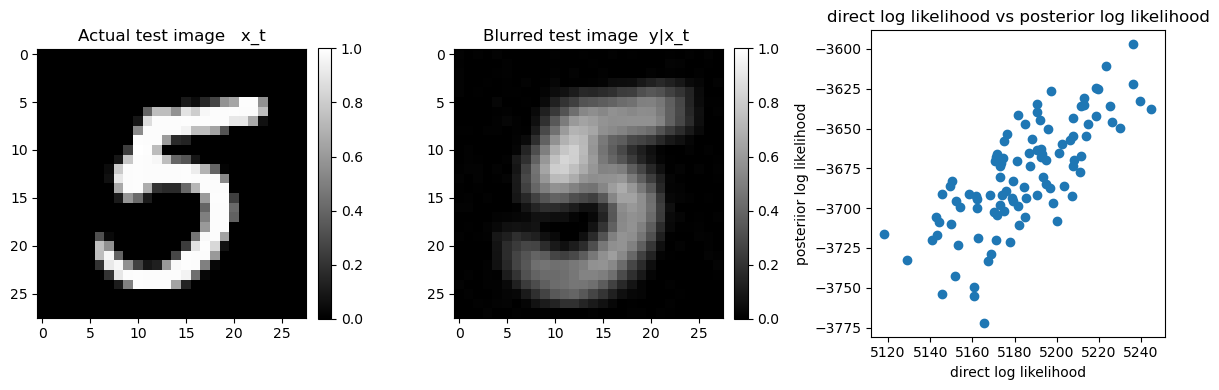

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12, 4))

im = axes.flat[0].imshow(digits_imgs_test[0][356]/255, vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0],fraction=0.046, pad=0.04)
axes[0].set_title("Actual test image   x_t")

im = axes.flat[1].imshow(blurred_testset[356,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
axes[1].set_title("Blurred test image  y|x_t ")

im = axes.flat[2].scatter(compare1[:,0],compare1[:,1])
#plt.colorbar(im, ax=axes[2],fraction=0.046, pad=0.04)
axes[2].set_title("direct log likelihood vs posterior log likelihood")
axes[2].set_xlabel('direct log likelihood')
axes[2].set_ylabel('posteriior log likelihood')
fig.tight_layout()
#plt.savefig('../figures_blur/CNN_direct_vs_posterior1.jpg')


In [60]:
compare = compare_direct_posterior(num_samples=100, im=1234)

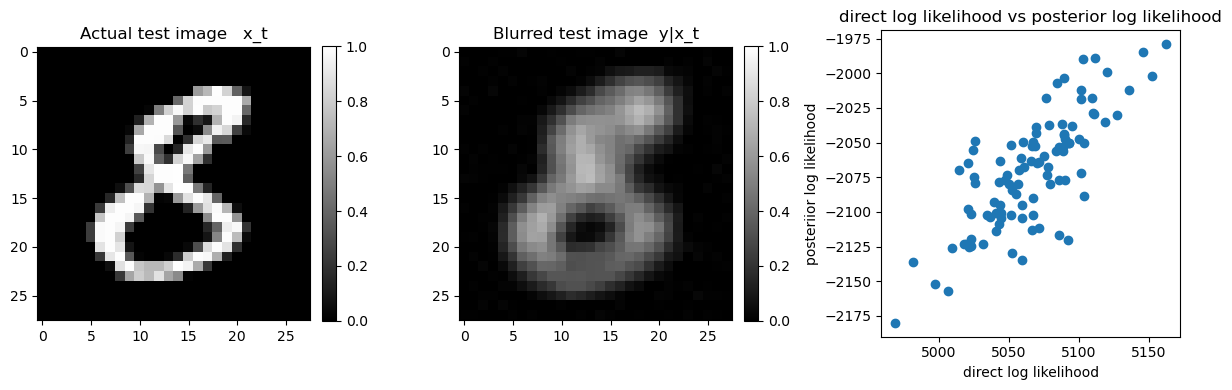

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12, 4))

im = axes.flat[0].imshow(digits_imgs_test[0][1234]/255, vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0],fraction=0.046, pad=0.04)
axes[0].set_title("Actual test image   x_t")

im = axes.flat[1].imshow(blurred_testset[1234,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
axes[1].set_title("Blurred test image  y|x_t")

im = axes.flat[2].scatter(compare[:,0],compare[:,1])
#plt.colorbar(im, ax=axes[2],fraction=0.046, pad=0.04)
axes[2].set_title("direct log likelihood vs posterior log likelihood")
axes[2].set_xlabel('direct log likelihood')
axes[2].set_ylabel('posteriior log likelihood')
fig.tight_layout()
#plt.savefig('../figures_blur/CNN_direct_vs_posterior2.jpg')


In [44]:
def importance_sampling(likelihoods, num_ims):
    bayes_loglik = likelihoods[:,1]
    direct_loglik = likelihoods[:,0]
    log_weights = np.zeros((num_ims,))
    for im in range(num_ims):
        log_weights[im] = bayes_loglik[im]-direct_loglik[im]
    log_weights = log_weights - np.max(log_weights)
    weights = np.exp(log_weights)/np.sum(np.exp(log_weights))
    #n_eff
    #E(x_s|y) = weighta*mean(x_s|y)

    return weights

In [45]:
def imp_samp_EX(im, num_samples):
    #many_samples = sample_many_ims(blurred_im=blurred_testset[im,0],num_samples=num_samples)
    torch.manual_seed(0)
    np.random.seed(0)
    #many_samples = sample_many_ims(blurred_im=torch.unsqueeze(blurred_testset[im], dim=0),num_samples=num_samples)
    many_samples = gen_im_mix_many_ims(pixel_cnn, (28,28), (5,5), torch.unsqueeze(blurred_testset[im],dim=0), (5,5), num_samples)
    #bayes_posterior = 
    log_likelihoods = compare_direct_posterior(num_samples=num_samples, im=im)
    weights = importance_sampling(log_likelihoods,num_samples)
    #weighted_ims = many_samples*weights
    weighted_ims = np.einsum('ijk,i->ijk',many_samples,weights)

    expected_ims = np.sum(weighted_ims,axis=0)
    #std_ims = np.std(weighted_ims, axis=0)
    std_ims = np.sqrt(np.sum(np.einsum('ijk,i->ijk',(many_samples-expected_ims)**2, weights),axis=0))
    n_eff = 1/np.sum(weights**2)
    return expected_ims, std_ims, n_eff, many_samples.detach().numpy()

In [46]:
E_xs_IS, std_xs_IS, N_eff_is, E_xs = imp_samp_EX(im=356, num_samples=200)

In [47]:
N_eff_is

1.0065092704992888

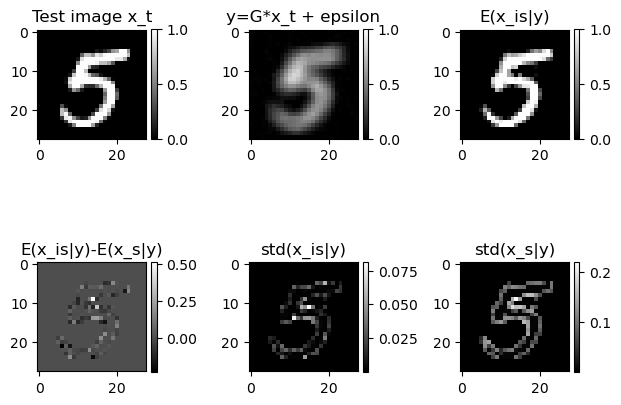

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=3)

im = axes.flat[0].imshow(digits_imgs_test[0][356]/255, vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Test image x_t")

im = axes.flat[1].imshow(blurred_testset[356,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("y=G*x_t + epsilon")

im = axes.flat[2].imshow(E_xs_IS,cmap='gray', vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,2],fraction=0.046, pad=0.04)
axes[0,2].set_title("E(x_is|y)")


im = axes.flat[3].imshow(E_xs_IS-np.mean(E_xs,axis=0),cmap='gray')#, vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("E(x_is|y)-E(x_s|y)")


im = axes.flat[4].imshow(std_xs_IS ,cmap='gray')#, vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("std(x_is|y)")


im = axes.flat[5].imshow(np.std(E_xs, axis=0),cmap='gray')#, vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,2],fraction=0.046, pad=0.04)
axes[1,2].set_title("std(x_s|y)")


fig.tight_layout()
#plt.savefig('../figures_blur/CNN_importance_samp1.jpg')

In [48]:
E_xs_IS_2, std_xs_IS_2, N_eff_is_2, E_xs_2 = imp_samp_EX(im=1234, num_samples=200)

In [49]:
N_eff_is_2

1.004348781705296

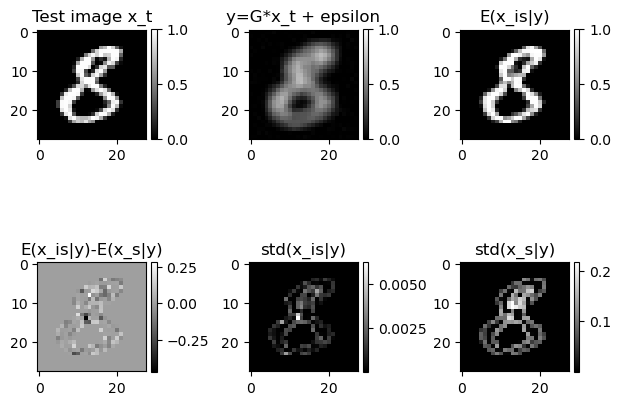

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=3)

im = axes.flat[0].imshow(digits_imgs_test[0][1234]/255, vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Test image x_t")

im = axes.flat[1].imshow(blurred_testset[1234,0], vmin=0, vmax=1,cmap='gray')
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("y=G*x_t + epsilon")

im = axes.flat[2].imshow(E_xs_IS_2,cmap='gray', vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,2],fraction=0.046, pad=0.04)
axes[0,2].set_title("E(x_is|y)")


im = axes.flat[3].imshow(E_xs_IS_2-np.mean(E_xs_2,axis=0),cmap='gray')#, vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("E(x_is|y)-E(x_s|y)")


im = axes.flat[4].imshow(std_xs_IS_2 ,cmap='gray')#, vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("std(x_is|y)")


im = axes.flat[5].imshow(np.std(E_xs_2, axis=0),cmap='gray')#, vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,2],fraction=0.046, pad=0.04)
axes[1,2].set_title("std(x_s|y)")


fig.tight_layout()
#plt.savefig('../figures_blur/CNN_importance_samp2.jpg')

In [84]:
new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix_trunc(pixel_cnn, (28,28), (5,5))

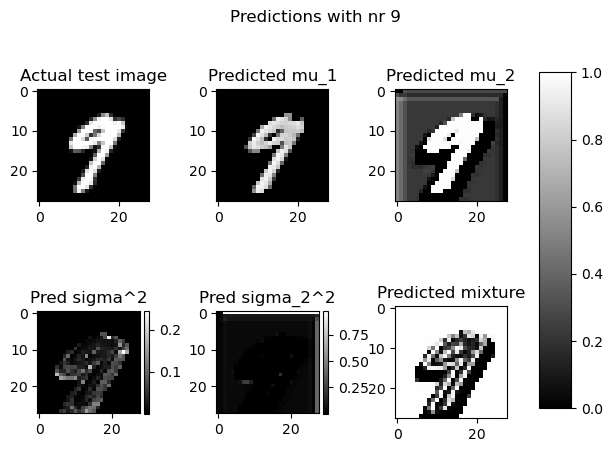

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=3)#,sharex=True, sharey=True)

im = axes.flat[0].imshow(new_im[0,0], vmin=0, vmax=1,cmap='gray')
#plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image")



im = axes.flat[1].imshow(pred_mu, vmin=0, vmax=1,cmap='gray')
#plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Predicted mu_1")



im = axes.flat[2].imshow(pred_mu2, vmin=0, vmax=1,cmap='gray')
#plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
axes[0,2].set_title("Predicted mu_2")


im = axes.flat[3].imshow(pred_sigma2,cmap='gray')
#plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
fig.colorbar(im,ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("Pred sigma^2")


im = axes.flat[4].imshow(pred_sigma2_2, cmap='gray')
fig.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
#plt.colorbar(im, ax=axes[1,1])#,fraction=0.046, pad=0.04)
axes[1,1].set_title("Pred sigma_2^2")


im = axes.flat[5].imshow(pred_pi_mix, vmin=0, vmax=1,cmap='gray')
axes[1,2].set_title("Predicted mixture")


fig.suptitle('Predictions with nr 9')
#plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
fig.tight_layout()
#fig.set_figheight(5)
#fig.set_figwidth(10)
#fig.colorbar(im, ax=axes[[0,1],2],fraction=0.46)#, pad=0.04)#fraction=0.46, pad=0.4)# ax=axes.ravel().tolist())
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('../../figures/CNN_pred.jpg')
plt.show()

In [91]:
sum(p.numel() for p in pixel_cnn.parameters() if p.requires_grad)

8036

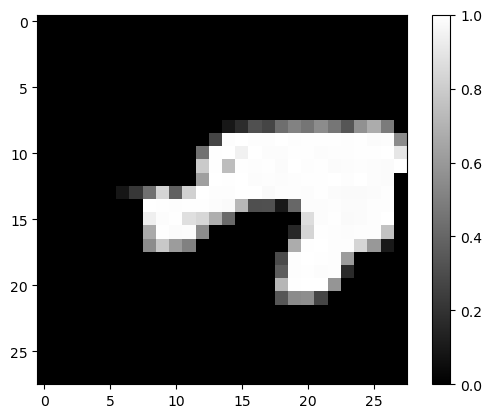

In [14]:
plt.imshow(new_im[0,0],cmap='gray')
plt.colorbar()

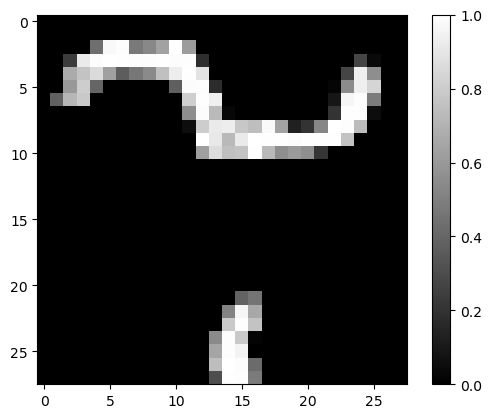

In [62]:
plt.imshow(new_im[0,0],cmap='gray')
plt.colorbar()

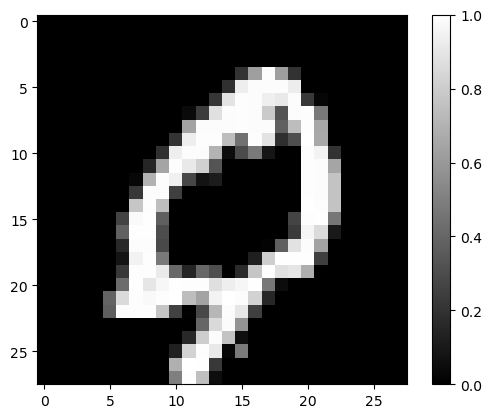

In [195]:
plt.imshow(new_im[0,0],cmap='gray')
plt.colorbar()

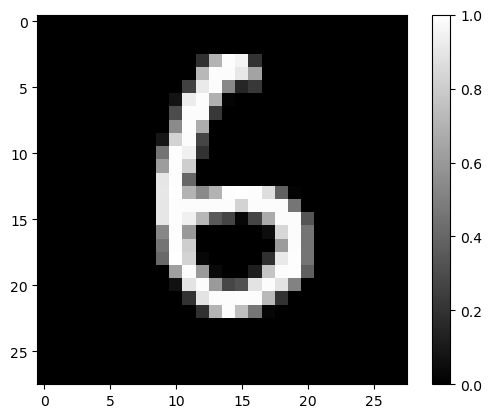

In [87]:
plt.imshow(torch.squeeze(digits_imgs_test[0][21:22]/255,dim=0),cmap='gray')
plt.colorbar()

In [60]:
torch.max(digits_imgs_test[0])

tensor(255, dtype=torch.uint8)

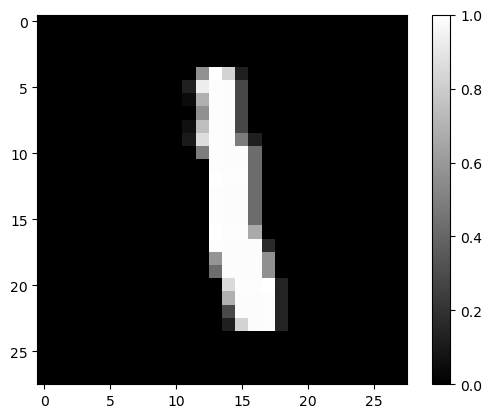

In [28]:

plt.imshow(torch.squeeze(digits_imgs_train[0][6:7]/255,dim=0),cmap='gray')
plt.colorbar()